In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import warnings


from torchsummary import summary
from pthflops import count_ops
warnings.filterwarnings('ignore')


torch.cuda.empty_cache()

In [52]:
#!unzip /content/Natural-Faces.zip                                         # CODE TO MOVE IMAGES FROM ONE FOLDER TO ANOTHER
# import os, random
# import shutil

# m=10

# src_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/train/contempt/"
# dst_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/test/contempt/"

# file_list = os.listdir(src_dir)

# for i in range(m):
    
#     a = random.choice(file_list)
#         #file_list.remove(a)
#     shutil.move(src_dir + a, dst_dir+ a)

In [53]:
def load_data(train_path, test_path, batch_size,input_size,mn,sd,shuffle_test=False):
    
    ######## Write your code here ########
    transform_dict={"src":transforms.Compose([transforms.Resize(size=input_size),transforms.RandomHorizontalFlip(),transforms.RandomAdjustSharpness(sharpness_factor=0.3),
            transforms.RandomVerticalFlip(),transforms.ToTensor(),transforms.Normalize(mean=mn,std=sd)])}

    train=datasets.ImageFolder(root=train_path,transform=transform_dict["src"],)
    
    
    labelslist=train.class_to_idx
    dataset_size = len(train)
    
    train_size = int(round(0.85 * dataset_size))
    val_size = int(round(0.15 * dataset_size))
    

    train_dataset,val_dataset = torch.utils.data.random_split(train,[train_size,val_size])
    test_dataset=datasets.ImageFolder(root=test_path,transform=transform_dict["src"])
    
    

    print('Size Of Train Dataset',len(train_dataset))
    print('Size Of Test Dataset',len(test_dataset))
    print('Size Of Validation Dataset',len(val_dataset))
   

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    shuffle=False, drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
 
      
    return data_loader_train, data_loader_test,data_loader_val,labelslist

In [54]:
# model1=models.resnet50(weights=True)               # FINDING NO OF LAYERS IN A MODEL AND DISPLAYING THEM
# ct=0
# for child in model1.children():
#     ct+=1
#     print('--------------')
#     print(child)
# print(ct)


model_vgg_frozen = models.vgg16(weights=True)         # CREATING MODELS FREEZING ALL THE LAYERS EXCEPT THE FC LAYER
ct = 0
for child in model_vgg_frozen.children():
    ct += 1
    if ct < 3:
        for param in child.parameters():
            param.requires_grad = False
            
model_resnet_frozen = models.resnet50(weights=True)
ct = 0
for child in model_resnet_frozen.children():
    ct += 1
    if ct < 10:
        for param in child.parameters():
            param.requires_grad = False

In [55]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  

# Natural Faces: 
	
# M: [0.5236, 0.5236, 0.5236]
# SD:[0.2351, 0.2351, 0.2351]


# Tiny:

# M: [0.5422, 0.4674, 0.4349]
# SD: [0.2665, 0.2500, 0.2517]

# Masked-Fer2013:

# M: [0.4652, 0.5198, 0.5736]
# SD: [0.2354, 0.2363, 0.2666]


In [56]:
def img_show(train_loader,lablist):

    
    
    images,labels=next(iter(train_loader))
    
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    print(lablist)
    
    figure = plt.figure(figsize=(5, 5))
    cols, rows = 3, 3             #Displays 9 images in a 3*3 grid
    for i in range(1, cols * rows + 1):

        img = images[i].squeeze()
        img_label = labels[i]
        
        label=(list(lablist.keys())[list(lablist.values()).index(img_label)])
        
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    



In [57]:
def grp_show(x,y,label,col,x_label,y_label,title,path):
    
    for i in range(0,len(y)):
      plt.plot(x, y[i], col[i], label=label[i])
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    
    plt.savefig(f'{path}{title}.jpg')
    
    plt.show()
 


In [58]:
def train_model(num_epochs,train_loader,val_loader):
    model.train()
    Train_steps = len(train_loader)
    Val_steps=len(val_loader)
    print('Total Steps',Train_steps)
    t1 = time.time()

    acclist_train=[]
    acclist_val=[]
    losslist_train=[]
    losslist_val=[]
    epc=[]
    cons_epchs=0
    loss_criteria=0.0001
    last_loss=np.Inf
    verbose=10
    

    for epoch in range(num_epochs):
        
        # exp_lr_scheduler.step()
        # print('Epoch:', epoch+1,'LR:', exp_lr_scheduler.get_lr())
        
        
        correct=0
        total=0
        loss_train=0
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)#Feedforward
            loss = criterion(outputs, labels)
            optimizer.zero_grad()#Gradient
            loss.backward()#Weights update
            optimizer.step()

            total+= labels.size(0) 

            _,predicted = torch.max(outputs.data, 1) #1 so that all the data is on the same line

            correct+= (predicted == labels).sum().item()
            loss_train+=loss.item()
            if (i + 1)  == Train_steps:

                  correct_v = 0                                                 #Validation Loop
                  total_v = 0
                  loss_v=0
                  for dataVal in val_loader:
                      images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                      outputs_v = model(images_v)
                      loss=criterion(outputs_v,labels_v)
                      _, predicted_v = torch.max(outputs_v.data, 1)
                      correct_v += (predicted_v == labels_v).sum().item()
                      total_v += labels_v.size(0)
                      loss_v+=loss.item()
              
                  print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.4f},'
                      .format(epoch + 1, num_epochs, loss_train/Train_steps, loss_v/Val_steps, (correct / total) * 100, (correct_v / total_v) * 100))
                  
                  acclist_train.append((correct / total) * 100)
                  acclist_val.append((correct_v / total_v) * 100)
                  losslist_train.append(loss_train/Train_steps)
                  losslist_val.append(loss_v/Val_steps)
                  epc.append(epoch+1)

                  
                  
                  current_loss=loss_v/Val_steps

                  if (last_loss-current_loss)<=loss_criteria:
                      cons_epchs += 1
                      last_loss = current_loss
                      
                      if cons_epchs >= verbose:
                        print('Loss Did Not Improve by more than 0.0001 for 10 epochs..Stopping')
                        print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
                        return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

                  else:
                    cons_epchs = 0

                  

 
               
    print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
    return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

In [59]:
from torch.cuda import device
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model,test_loader):
    model.eval() 

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        
        
        print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
        ConfusionMatrixDisplay(conf_mat).plot()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


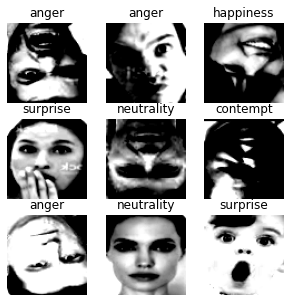

Device: cuda:0
Total Steps 62
Epoch [1/150], Training Loss: 2.5924, Validation Loss: 2.1118, Training Accuracy: 16.27%, Validation Accuracy: 19.3133,
Epoch [2/150], Training Loss: 2.0584, Validation Loss: 2.0476, Training Accuracy: 19.93%, Validation Accuracy: 17.5966,
Epoch [3/150], Training Loss: 2.0289, Validation Loss: 2.0458, Training Accuracy: 20.18%, Validation Accuracy: 21.4592,
Epoch [4/150], Training Loss: 1.9950, Validation Loss: 1.9674, Training Accuracy: 21.29%, Validation Accuracy: 23.1760,
Epoch [5/150], Training Loss: 1.8929, Validation Loss: 1.8827, Training Accuracy: 26.80%, Validation Accuracy: 23.6052,
Epoch [6/150], Training Loss: 1.8351, Validation Loss: 1.8633, Training Accuracy: 31.02%, Validation Accuracy: 32.6180,
Epoch [7/150], Training Loss: 1.7873, Validation Loss: 1.8012, Training Accuracy: 34.30%, Validation Accuracy: 35.3362,
Epoch [8/150], Training Loss: 1.7060, Validation Loss: 1.6885, Training Accuracy: 37.96%, Validation Accuracy: 36.1946,
Epoch [9/1

Epoch [69/150], Training Loss: 0.1013, Validation Loss: 2.7997, Training Accuracy: 96.62%, Validation Accuracy: 51.3591,
Epoch [70/150], Training Loss: 0.1054, Validation Loss: 2.6858, Training Accuracy: 96.46%, Validation Accuracy: 50.9299,
Epoch [71/150], Training Loss: 0.0969, Validation Loss: 2.7308, Training Accuracy: 97.12%, Validation Accuracy: 49.7854,
Epoch [72/150], Training Loss: 0.1012, Validation Loss: 2.7907, Training Accuracy: 96.94%, Validation Accuracy: 52.0744,
Epoch [73/150], Training Loss: 0.0983, Validation Loss: 2.5315, Training Accuracy: 97.20%, Validation Accuracy: 52.9328,
Epoch [74/150], Training Loss: 0.0880, Validation Loss: 2.4547, Training Accuracy: 97.02%, Validation Accuracy: 54.0773,
Epoch [75/150], Training Loss: 0.0973, Validation Loss: 2.6022, Training Accuracy: 97.04%, Validation Accuracy: 50.5007,
Epoch [76/150], Training Loss: 0.0964, Validation Loss: 2.5254, Training Accuracy: 97.20%, Validation Accuracy: 53.0758,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0530, Validation Loss: 3.4864, Training Accuracy: 98.31%, Validation Accuracy: 52.3605,
Epoch [138/150], Training Loss: 0.0576, Validation Loss: 3.2954, Training Accuracy: 98.03%, Validation Accuracy: 51.0730,
Epoch [139/150], Training Loss: 0.0584, Validation Loss: 3.4065, Training Accuracy: 97.93%, Validation Accuracy: 50.7868,
Epoch [140/150], Training Loss: 0.0714, Validation Loss: 3.1056, Training Accuracy: 97.37%, Validation Accuracy: 50.6438,
Epoch [141/150], Training Loss: 0.0599, Validation Loss: 3.5573, Training Accuracy: 97.80%, Validation Accuracy: 51.5021,
Epoch [142/150], Training Loss: 0.0583, Validation Loss: 3.1111, Training Accuracy: 98.08%, Validation Accuracy: 51.6452,
Epoch [143/150], Training Loss: 0.0576, Validation Loss: 3.0451, Training Accuracy: 97.90%, Validation Accuracy: 52.0744,
Epoch [144/150], Training Loss: 0.0802, Validation Loss: 2.6716, Training Accuracy: 97.55%, Validation Accuracy: 50.0715,
Epoch [145/150], Trainin

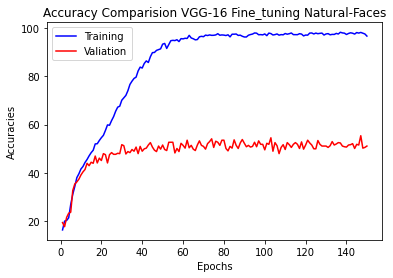

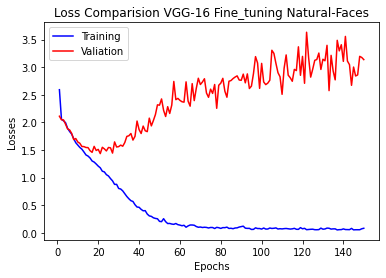

Test Accuracy of the model on the 900 test images: 53.888888888888886 %


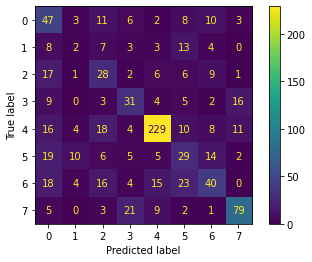

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


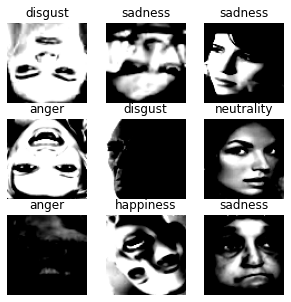

Device: cuda:0
Total Steps 62
Epoch [1/150], Training Loss: 2.5436, Validation Loss: 2.0029, Training Accuracy: 21.14%, Validation Accuracy: 21.7454,
Epoch [2/150], Training Loss: 1.9488, Validation Loss: 2.0083, Training Accuracy: 23.82%, Validation Accuracy: 20.3147,
Epoch [3/150], Training Loss: 1.9372, Validation Loss: 1.9384, Training Accuracy: 24.60%, Validation Accuracy: 26.3233,
Epoch [4/150], Training Loss: 1.9034, Validation Loss: 1.9803, Training Accuracy: 25.59%, Validation Accuracy: 24.1774,
Epoch [5/150], Training Loss: 1.8845, Validation Loss: 1.9203, Training Accuracy: 26.12%, Validation Accuracy: 29.7568,
Epoch [6/150], Training Loss: 1.8636, Validation Loss: 1.9237, Training Accuracy: 28.09%, Validation Accuracy: 28.3262,
Epoch [7/150], Training Loss: 1.8619, Validation Loss: 1.9459, Training Accuracy: 27.91%, Validation Accuracy: 26.3233,
Epoch [8/150], Training Loss: 1.8554, Validation Loss: 1.9232, Training Accuracy: 27.76%, Validation Accuracy: 27.7539,
Epoch [9/1

Epoch [69/150], Training Loss: 0.2301, Validation Loss: 3.1313, Training Accuracy: 92.37%, Validation Accuracy: 37.0529,
Epoch [70/150], Training Loss: 0.2335, Validation Loss: 3.2515, Training Accuracy: 92.37%, Validation Accuracy: 38.3405,
Epoch [71/150], Training Loss: 0.2121, Validation Loss: 3.2861, Training Accuracy: 93.08%, Validation Accuracy: 38.7697,
Epoch [72/150], Training Loss: 0.2246, Validation Loss: 3.1294, Training Accuracy: 92.88%, Validation Accuracy: 39.3419,
Epoch [73/150], Training Loss: 0.2048, Validation Loss: 3.2869, Training Accuracy: 93.43%, Validation Accuracy: 39.7711,
Epoch [74/150], Training Loss: 0.1967, Validation Loss: 3.2503, Training Accuracy: 93.81%, Validation Accuracy: 38.3405,
Epoch [75/150], Training Loss: 0.2179, Validation Loss: 3.1920, Training Accuracy: 92.95%, Validation Accuracy: 41.2017,
Epoch [76/150], Training Loss: 0.1976, Validation Loss: 3.2748, Training Accuracy: 93.96%, Validation Accuracy: 39.6280,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.1013, Validation Loss: 3.7909, Training Accuracy: 96.67%, Validation Accuracy: 43.4907,
Epoch [138/150], Training Loss: 0.1187, Validation Loss: 3.9550, Training Accuracy: 96.19%, Validation Accuracy: 41.3448,
Epoch [139/150], Training Loss: 0.0852, Validation Loss: 4.0772, Training Accuracy: 97.37%, Validation Accuracy: 40.4864,
Epoch [140/150], Training Loss: 0.1023, Validation Loss: 3.6527, Training Accuracy: 96.74%, Validation Accuracy: 42.2031,
Epoch [141/150], Training Loss: 0.0977, Validation Loss: 3.7399, Training Accuracy: 96.67%, Validation Accuracy: 42.7754,
Epoch [142/150], Training Loss: 0.0982, Validation Loss: 3.9891, Training Accuracy: 96.67%, Validation Accuracy: 39.1989,
Epoch [143/150], Training Loss: 0.1153, Validation Loss: 3.9517, Training Accuracy: 96.44%, Validation Accuracy: 39.0558,
Epoch [144/150], Training Loss: 0.1159, Validation Loss: 3.9915, Training Accuracy: 96.51%, Validation Accuracy: 42.6323,
Epoch [145/150], Trainin

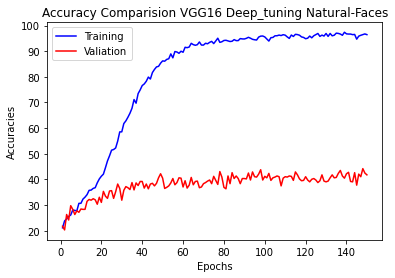

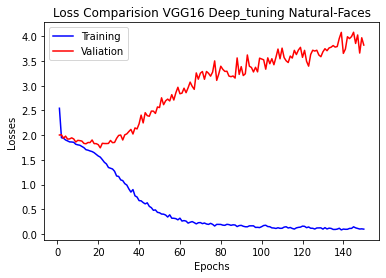

Test Accuracy of the model on the 900 test images: 43.888888888888886 %


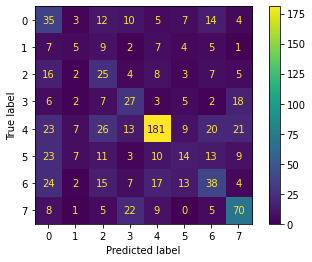

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 3959
Size Of Test Dataset 900
Size Of Validation Dataset 699
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutrality': 5, 'sadness': 6, 'surprise': 7}


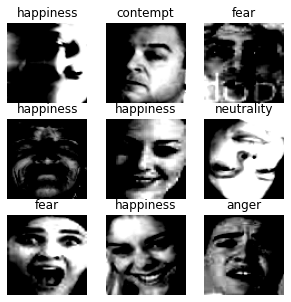

Device: cuda:0
Total Steps 62
Epoch [1/150], Training Loss: 2.5719, Validation Loss: 2.0022, Training Accuracy: 18.97%, Validation Accuracy: 23.1760,
Epoch [2/150], Training Loss: 2.0091, Validation Loss: 2.0016, Training Accuracy: 20.54%, Validation Accuracy: 22.4607,
Epoch [3/150], Training Loss: 1.9851, Validation Loss: 1.9859, Training Accuracy: 21.70%, Validation Accuracy: 23.3190,
Epoch [4/150], Training Loss: 1.9453, Validation Loss: 1.8969, Training Accuracy: 24.96%, Validation Accuracy: 26.8956,
Epoch [5/150], Training Loss: 1.8948, Validation Loss: 1.8777, Training Accuracy: 26.95%, Validation Accuracy: 25.0358,
Epoch [6/150], Training Loss: 1.8376, Validation Loss: 1.8073, Training Accuracy: 28.80%, Validation Accuracy: 31.6166,
Epoch [7/150], Training Loss: 1.8011, Validation Loss: 1.7947, Training Accuracy: 31.35%, Validation Accuracy: 35.4793,
Epoch [8/150], Training Loss: 1.7502, Validation Loss: 1.7288, Training Accuracy: 33.77%, Validation Accuracy: 36.1946,
Epoch [9/1

Epoch [69/150], Training Loss: 0.2523, Validation Loss: 2.6741, Training Accuracy: 91.56%, Validation Accuracy: 49.4993,
Epoch [70/150], Training Loss: 0.2250, Validation Loss: 2.6079, Training Accuracy: 92.60%, Validation Accuracy: 52.0744,
Epoch [71/150], Training Loss: 0.1904, Validation Loss: 2.9488, Training Accuracy: 93.18%, Validation Accuracy: 46.2089,
Epoch [72/150], Training Loss: 0.2478, Validation Loss: 2.6455, Training Accuracy: 91.84%, Validation Accuracy: 47.9256,
Epoch [73/150], Training Loss: 0.2084, Validation Loss: 2.7546, Training Accuracy: 93.03%, Validation Accuracy: 48.9270,
Epoch [74/150], Training Loss: 0.1814, Validation Loss: 2.7793, Training Accuracy: 94.32%, Validation Accuracy: 50.2146,
Epoch [75/150], Training Loss: 0.2047, Validation Loss: 2.8101, Training Accuracy: 92.52%, Validation Accuracy: 46.6381,
Epoch [76/150], Training Loss: 0.1650, Validation Loss: 2.5908, Training Accuracy: 94.80%, Validation Accuracy: 51.0730,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0788, Validation Loss: 3.2549, Training Accuracy: 97.35%, Validation Accuracy: 48.4979,
Epoch [138/150], Training Loss: 0.0836, Validation Loss: 3.3578, Training Accuracy: 97.04%, Validation Accuracy: 48.4979,
Epoch [139/150], Training Loss: 0.0735, Validation Loss: 3.1888, Training Accuracy: 97.37%, Validation Accuracy: 50.2146,
Epoch [140/150], Training Loss: 0.0894, Validation Loss: 3.2344, Training Accuracy: 96.69%, Validation Accuracy: 49.6423,
Epoch [141/150], Training Loss: 0.0864, Validation Loss: 3.2943, Training Accuracy: 96.99%, Validation Accuracy: 50.3577,
Epoch [142/150], Training Loss: 0.1108, Validation Loss: 3.0829, Training Accuracy: 96.39%, Validation Accuracy: 48.0687,
Epoch [143/150], Training Loss: 0.1007, Validation Loss: 3.2201, Training Accuracy: 96.62%, Validation Accuracy: 50.6438,
Epoch [144/150], Training Loss: 0.0534, Validation Loss: 3.2602, Training Accuracy: 98.11%, Validation Accuracy: 49.9285,
Epoch [145/150], Trainin

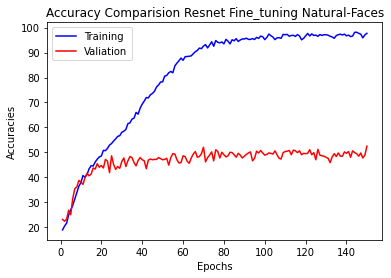

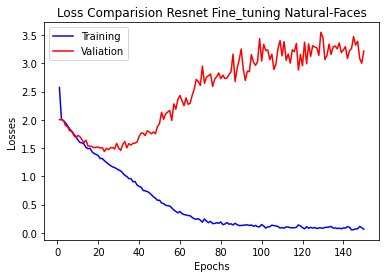

Test Accuracy of the model on the 900 test images: 51.0 %


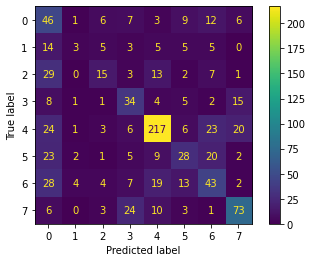

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


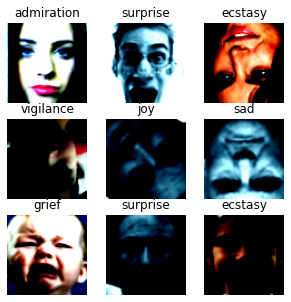

Device: cuda:0
Total Steps 432
Epoch [1/150], Training Loss: 2.5080, Validation Loss: 1.8564, Training Accuracy: 20.31%, Validation Accuracy: 31.1590,
Epoch [2/150], Training Loss: 1.6760, Validation Loss: 1.6227, Training Accuracy: 35.62%, Validation Accuracy: 37.5795,
Epoch [3/150], Training Loss: 1.5325, Validation Loss: 1.5131, Training Accuracy: 41.25%, Validation Accuracy: 41.6821,
Epoch [4/150], Training Loss: 1.4403, Validation Loss: 1.4921, Training Accuracy: 45.06%, Validation Accuracy: 44.2051,
Epoch [5/150], Training Loss: 1.3638, Validation Loss: 1.4216, Training Accuracy: 47.89%, Validation Accuracy: 44.9846,
Epoch [6/150], Training Loss: 1.3033, Validation Loss: 1.4051, Training Accuracy: 50.70%, Validation Accuracy: 46.7077,
Epoch [7/150], Training Loss: 1.2488, Validation Loss: 1.4066, Training Accuracy: 53.05%, Validation Accuracy: 46.9538,
Epoch [8/150], Training Loss: 1.1906, Validation Loss: 1.4138, Training Accuracy: 55.81%, Validation Accuracy: 47.6923,
Epoch [9/

Epoch [69/150], Training Loss: 0.1320, Validation Loss: 2.6118, Training Accuracy: 95.75%, Validation Accuracy: 48.1846,
Epoch [70/150], Training Loss: 0.1316, Validation Loss: 2.5795, Training Accuracy: 95.58%, Validation Accuracy: 48.2872,
Epoch [71/150], Training Loss: 0.1283, Validation Loss: 2.7856, Training Accuracy: 95.71%, Validation Accuracy: 48.3487,
Epoch [72/150], Training Loss: 0.1244, Validation Loss: 2.9161, Training Accuracy: 95.90%, Validation Accuracy: 49.1692,
Epoch [73/150], Training Loss: 0.1212, Validation Loss: 3.0867, Training Accuracy: 96.03%, Validation Accuracy: 47.0974,
Epoch [74/150], Training Loss: 0.1247, Validation Loss: 2.8143, Training Accuracy: 95.89%, Validation Accuracy: 48.7590,
Epoch [75/150], Training Loss: 0.1172, Validation Loss: 2.8157, Training Accuracy: 96.30%, Validation Accuracy: 48.0410,
Epoch [76/150], Training Loss: 0.1264, Validation Loss: 2.8875, Training Accuracy: 95.91%, Validation Accuracy: 48.3077,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0803, Validation Loss: 3.4900, Training Accuracy: 97.30%, Validation Accuracy: 47.8359,
Epoch [138/150], Training Loss: 0.0804, Validation Loss: 3.7038, Training Accuracy: 97.45%, Validation Accuracy: 48.2256,
Epoch [139/150], Training Loss: 0.0820, Validation Loss: 3.5696, Training Accuracy: 97.38%, Validation Accuracy: 48.3487,
Epoch [140/150], Training Loss: 0.0879, Validation Loss: 3.1773, Training Accuracy: 97.10%, Validation Accuracy: 48.3897,
Epoch [141/150], Training Loss: 0.0797, Validation Loss: 3.1155, Training Accuracy: 97.53%, Validation Accuracy: 47.6513,
Epoch [142/150], Training Loss: 0.0838, Validation Loss: 3.3794, Training Accuracy: 97.21%, Validation Accuracy: 48.4308,
Epoch [143/150], Training Loss: 0.0797, Validation Loss: 3.3837, Training Accuracy: 97.38%, Validation Accuracy: 47.8974,
Epoch [144/150], Training Loss: 0.0775, Validation Loss: 3.4668, Training Accuracy: 97.55%, Validation Accuracy: 48.0615,
Epoch [145/150], Trainin

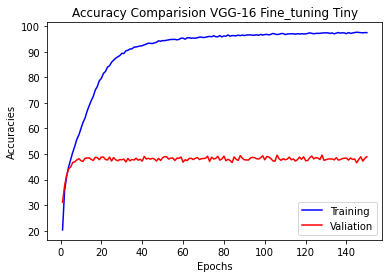

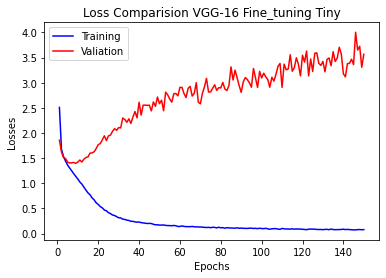

Test Accuracy of the model on the 9837 test images: 52.36352546508082 %


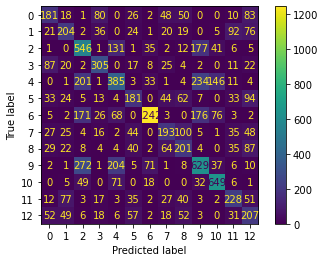

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


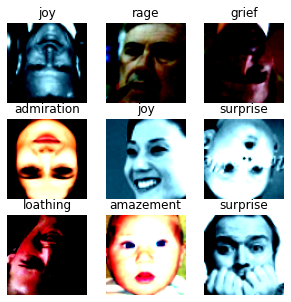

Device: cuda:0
Total Steps 432
Epoch [1/150], Training Loss: 2.4289, Validation Loss: 1.8328, Training Accuracy: 23.93%, Validation Accuracy: 31.1179,
Epoch [2/150], Training Loss: 1.7700, Validation Loss: 1.7600, Training Accuracy: 33.20%, Validation Accuracy: 34.2359,
Epoch [3/150], Training Loss: 1.6782, Validation Loss: 1.7295, Training Accuracy: 36.70%, Validation Accuracy: 34.1744,
Epoch [4/150], Training Loss: 1.6028, Validation Loss: 1.6589, Training Accuracy: 39.80%, Validation Accuracy: 38.3179,
Epoch [5/150], Training Loss: 1.5358, Validation Loss: 1.6422, Training Accuracy: 42.68%, Validation Accuracy: 39.0359,
Epoch [6/150], Training Loss: 1.4783, Validation Loss: 1.6435, Training Accuracy: 45.08%, Validation Accuracy: 39.5077,
Epoch [7/150], Training Loss: 1.4206, Validation Loss: 1.6252, Training Accuracy: 47.23%, Validation Accuracy: 40.1436,
Epoch [8/150], Training Loss: 1.3675, Validation Loss: 1.6065, Training Accuracy: 49.27%, Validation Accuracy: 40.9846,
Epoch [9/

Epoch [69/150], Training Loss: 0.1825, Validation Loss: 3.0372, Training Accuracy: 94.03%, Validation Accuracy: 43.2615,
Epoch [70/150], Training Loss: 0.1759, Validation Loss: 3.1413, Training Accuracy: 94.19%, Validation Accuracy: 43.7538,
Epoch [71/150], Training Loss: 0.1689, Validation Loss: 3.1649, Training Accuracy: 94.39%, Validation Accuracy: 43.4872,
Epoch [72/150], Training Loss: 0.1685, Validation Loss: 3.1420, Training Accuracy: 94.27%, Validation Accuracy: 43.4462,
Epoch [73/150], Training Loss: 0.1681, Validation Loss: 3.1665, Training Accuracy: 94.51%, Validation Accuracy: 42.6256,
Epoch [74/150], Training Loss: 0.1698, Validation Loss: 3.1827, Training Accuracy: 94.25%, Validation Accuracy: 43.6923,
Epoch [75/150], Training Loss: 0.1646, Validation Loss: 3.2166, Training Accuracy: 94.58%, Validation Accuracy: 43.6103,
Epoch [76/150], Training Loss: 0.1601, Validation Loss: 3.2547, Training Accuracy: 94.68%, Validation Accuracy: 43.1179,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0874, Validation Loss: 3.6626, Training Accuracy: 97.10%, Validation Accuracy: 43.2821,
Epoch [138/150], Training Loss: 0.0982, Validation Loss: 3.7496, Training Accuracy: 96.81%, Validation Accuracy: 42.9333,
Epoch [139/150], Training Loss: 0.1006, Validation Loss: 3.6755, Training Accuracy: 96.55%, Validation Accuracy: 43.2000,
Epoch [140/150], Training Loss: 0.0898, Validation Loss: 3.8370, Training Accuracy: 96.97%, Validation Accuracy: 43.7949,
Epoch [141/150], Training Loss: 0.0967, Validation Loss: 3.7425, Training Accuracy: 96.66%, Validation Accuracy: 44.1436,
Epoch [142/150], Training Loss: 0.0886, Validation Loss: 3.7553, Training Accuracy: 96.98%, Validation Accuracy: 43.5692,
Epoch [143/150], Training Loss: 0.0907, Validation Loss: 3.7509, Training Accuracy: 97.05%, Validation Accuracy: 43.7949,
Epoch [144/150], Training Loss: 0.0915, Validation Loss: 3.8147, Training Accuracy: 96.97%, Validation Accuracy: 43.3026,
Epoch [145/150], Trainin

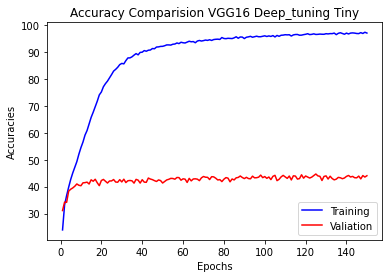

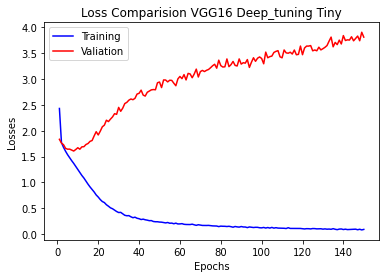

Test Accuracy of the model on the 9837 test images: 47.01636677848938 %


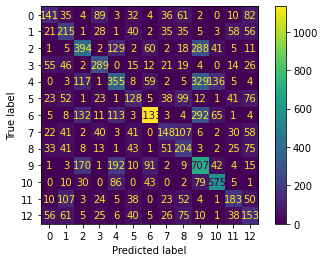

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


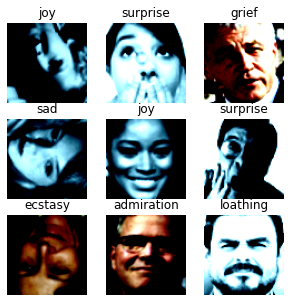

Device: cuda:0
Total Steps 432
Epoch [1/150], Training Loss: 2.5069, Validation Loss: 1.8617, Training Accuracy: 20.67%, Validation Accuracy: 29.3744,
Epoch [2/150], Training Loss: 1.7882, Validation Loss: 1.7676, Training Accuracy: 31.31%, Validation Accuracy: 32.3282,
Epoch [3/150], Training Loss: 1.7032, Validation Loss: 1.6694, Training Accuracy: 34.88%, Validation Accuracy: 36.1641,
Epoch [4/150], Training Loss: 1.6471, Validation Loss: 1.6367, Training Accuracy: 37.14%, Validation Accuracy: 37.0051,
Epoch [5/150], Training Loss: 1.6065, Validation Loss: 1.7006, Training Accuracy: 38.99%, Validation Accuracy: 36.3897,
Epoch [6/150], Training Loss: 1.5658, Validation Loss: 1.5729, Training Accuracy: 40.40%, Validation Accuracy: 40.5128,
Epoch [7/150], Training Loss: 1.5271, Validation Loss: 1.5627, Training Accuracy: 41.12%, Validation Accuracy: 41.1692,
Epoch [8/150], Training Loss: 1.4995, Validation Loss: 1.5399, Training Accuracy: 43.16%, Validation Accuracy: 41.3538,
Epoch [9/

Epoch [69/150], Training Loss: 0.2391, Validation Loss: 3.1067, Training Accuracy: 91.82%, Validation Accuracy: 43.7538,
Epoch [70/150], Training Loss: 0.2496, Validation Loss: 3.0731, Training Accuracy: 91.47%, Validation Accuracy: 43.6308,
Epoch [71/150], Training Loss: 0.2373, Validation Loss: 3.2080, Training Accuracy: 91.85%, Validation Accuracy: 43.0974,
Epoch [72/150], Training Loss: 0.2326, Validation Loss: 3.0810, Training Accuracy: 92.08%, Validation Accuracy: 43.6103,
Epoch [73/150], Training Loss: 0.2262, Validation Loss: 3.1144, Training Accuracy: 92.25%, Validation Accuracy: 43.1795,
Epoch [74/150], Training Loss: 0.2256, Validation Loss: 3.1038, Training Accuracy: 92.14%, Validation Accuracy: 43.2205,
Epoch [75/150], Training Loss: 0.2237, Validation Loss: 3.2788, Training Accuracy: 92.41%, Validation Accuracy: 42.4615,
Epoch [76/150], Training Loss: 0.2195, Validation Loss: 3.2496, Training Accuracy: 92.68%, Validation Accuracy: 43.6923,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.1222, Validation Loss: 3.8751, Training Accuracy: 95.97%, Validation Accuracy: 44.1026,
Epoch [138/150], Training Loss: 0.1180, Validation Loss: 4.2360, Training Accuracy: 95.95%, Validation Accuracy: 44.5744,
Epoch [139/150], Training Loss: 0.1224, Validation Loss: 4.0758, Training Accuracy: 95.93%, Validation Accuracy: 43.7128,
Epoch [140/150], Training Loss: 0.1080, Validation Loss: 4.0162, Training Accuracy: 96.48%, Validation Accuracy: 43.7333,
Epoch [141/150], Training Loss: 0.1208, Validation Loss: 4.0328, Training Accuracy: 96.03%, Validation Accuracy: 43.2000,
Epoch [142/150], Training Loss: 0.1103, Validation Loss: 3.9434, Training Accuracy: 96.40%, Validation Accuracy: 42.9333,
Epoch [143/150], Training Loss: 0.1121, Validation Loss: 4.0997, Training Accuracy: 96.27%, Validation Accuracy: 42.0923,
Epoch [144/150], Training Loss: 0.1135, Validation Loss: 3.9717, Training Accuracy: 96.26%, Validation Accuracy: 43.5692,
Epoch [145/150], Trainin

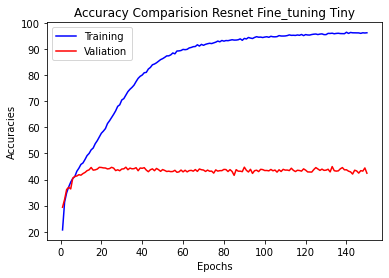

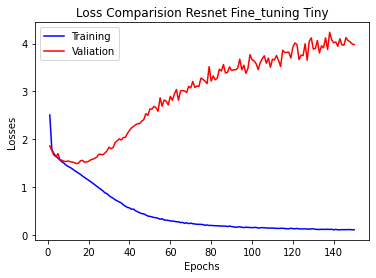

Test Accuracy of the model on the 9837 test images: 46.58940733963607 %


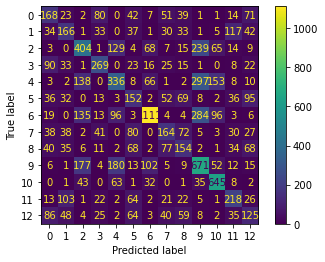

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


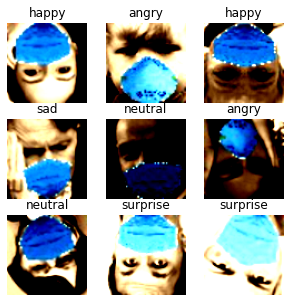

Device: cuda:0
Total Steps 228
Epoch [1/150], Training Loss: 1.5386, Validation Loss: 1.0406, Training Accuracy: 42.60%, Validation Accuracy: 52.4571,
Epoch [2/150], Training Loss: 0.9737, Validation Loss: 0.9189, Training Accuracy: 55.63%, Validation Accuracy: 58.1903,
Epoch [3/150], Training Loss: 0.8980, Validation Loss: 0.9103, Training Accuracy: 60.11%, Validation Accuracy: 58.1123,
Epoch [4/150], Training Loss: 0.8399, Validation Loss: 0.8414, Training Accuracy: 63.84%, Validation Accuracy: 63.1825,
Epoch [5/150], Training Loss: 0.7722, Validation Loss: 0.8961, Training Accuracy: 67.53%, Validation Accuracy: 63.5725,
Epoch [6/150], Training Loss: 0.7305, Validation Loss: 0.8313, Training Accuracy: 69.58%, Validation Accuracy: 65.6786,
Epoch [7/150], Training Loss: 0.6700, Validation Loss: 0.8784, Training Accuracy: 72.85%, Validation Accuracy: 63.6115,
Epoch [8/150], Training Loss: 0.6160, Validation Loss: 0.8265, Training Accuracy: 75.78%, Validation Accuracy: 65.8736,
Epoch [9/

Epoch [69/150], Training Loss: 0.0469, Validation Loss: 1.9709, Training Accuracy: 98.42%, Validation Accuracy: 68.9938,
Epoch [70/150], Training Loss: 0.0401, Validation Loss: 1.7111, Training Accuracy: 98.67%, Validation Accuracy: 69.2278,
Epoch [71/150], Training Loss: 0.0387, Validation Loss: 1.8393, Training Accuracy: 98.80%, Validation Accuracy: 68.9158,
Epoch [72/150], Training Loss: 0.0523, Validation Loss: 2.4103, Training Accuracy: 98.36%, Validation Accuracy: 68.4087,
Epoch [73/150], Training Loss: 0.1094, Validation Loss: 1.7418, Training Accuracy: 96.27%, Validation Accuracy: 68.6817,
Epoch [74/150], Training Loss: 0.0491, Validation Loss: 1.7868, Training Accuracy: 98.29%, Validation Accuracy: 69.1888,
Epoch [75/150], Training Loss: 0.0444, Validation Loss: 1.9381, Training Accuracy: 98.42%, Validation Accuracy: 70.0858,
Epoch [76/150], Training Loss: 0.0514, Validation Loss: 1.8336, Training Accuracy: 98.43%, Validation Accuracy: 69.4228,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0248, Validation Loss: 2.0851, Training Accuracy: 99.18%, Validation Accuracy: 69.1498,
Epoch [138/150], Training Loss: 0.0257, Validation Loss: 1.9335, Training Accuracy: 99.22%, Validation Accuracy: 69.7348,
Epoch [139/150], Training Loss: 0.0345, Validation Loss: 2.0495, Training Accuracy: 98.89%, Validation Accuracy: 68.7988,
Epoch [140/150], Training Loss: 0.0390, Validation Loss: 1.9467, Training Accuracy: 98.80%, Validation Accuracy: 69.6568,
Epoch [141/150], Training Loss: 0.0302, Validation Loss: 2.1354, Training Accuracy: 99.00%, Validation Accuracy: 69.3448,
Epoch [142/150], Training Loss: 0.0279, Validation Loss: 1.8732, Training Accuracy: 99.13%, Validation Accuracy: 71.0608,
Epoch [143/150], Training Loss: 0.0320, Validation Loss: 1.8611, Training Accuracy: 98.89%, Validation Accuracy: 69.3058,
Epoch [144/150], Training Loss: 0.0398, Validation Loss: 1.9794, Training Accuracy: 98.72%, Validation Accuracy: 69.8908,
Epoch [145/150], Trainin

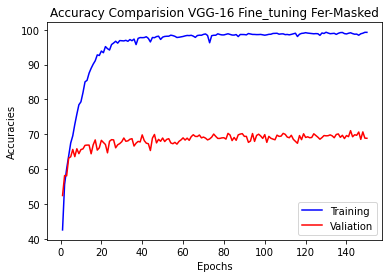

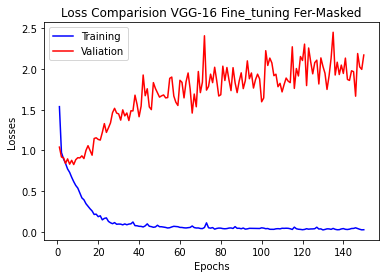

Test Accuracy of the model on the 4250 test images: 52.51764705882353 %


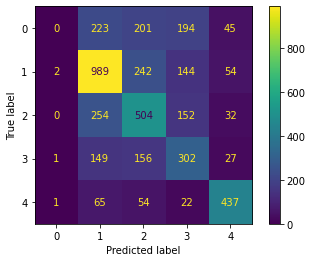

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


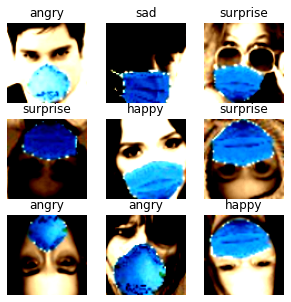

Device: cuda:0
Total Steps 228
Epoch [1/150], Training Loss: 1.7938, Validation Loss: 1.0625, Training Accuracy: 46.47%, Validation Accuracy: 52.6131,
Epoch [2/150], Training Loss: 0.9198, Validation Loss: 0.9628, Training Accuracy: 60.64%, Validation Accuracy: 58.8144,
Epoch [3/150], Training Loss: 0.8202, Validation Loss: 0.9426, Training Accuracy: 65.67%, Validation Accuracy: 59.4384,
Epoch [4/150], Training Loss: 0.7466, Validation Loss: 0.9320, Training Accuracy: 69.91%, Validation Accuracy: 60.7254,
Epoch [5/150], Training Loss: 0.6711, Validation Loss: 0.9515, Training Accuracy: 73.44%, Validation Accuracy: 61.4275,
Epoch [6/150], Training Loss: 0.6132, Validation Loss: 0.9686, Training Accuracy: 76.09%, Validation Accuracy: 61.0764,
Epoch [7/150], Training Loss: 0.5541, Validation Loss: 0.9949, Training Accuracy: 79.21%, Validation Accuracy: 60.6864,
Epoch [8/150], Training Loss: 0.4927, Validation Loss: 1.0056, Training Accuracy: 81.70%, Validation Accuracy: 61.7785,
Epoch [9/

Epoch [69/150], Training Loss: 0.0499, Validation Loss: 1.8575, Training Accuracy: 98.28%, Validation Accuracy: 63.9626,
Epoch [70/150], Training Loss: 0.0359, Validation Loss: 1.9551, Training Accuracy: 98.75%, Validation Accuracy: 64.4696,
Epoch [71/150], Training Loss: 0.0371, Validation Loss: 1.9304, Training Accuracy: 98.82%, Validation Accuracy: 64.4306,
Epoch [72/150], Training Loss: 0.0353, Validation Loss: 2.1030, Training Accuracy: 98.98%, Validation Accuracy: 64.6646,
Epoch [73/150], Training Loss: 0.0851, Validation Loss: 1.8064, Training Accuracy: 97.17%, Validation Accuracy: 63.7676,
Epoch [74/150], Training Loss: 0.0879, Validation Loss: 1.8875, Training Accuracy: 97.14%, Validation Accuracy: 63.2215,
Epoch [75/150], Training Loss: 0.0828, Validation Loss: 1.7996, Training Accuracy: 97.45%, Validation Accuracy: 64.6256,
Epoch [76/150], Training Loss: 0.0996, Validation Loss: 1.8096, Training Accuracy: 96.77%, Validation Accuracy: 63.4945,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0349, Validation Loss: 2.0158, Training Accuracy: 99.32%, Validation Accuracy: 64.0796,
Epoch [138/150], Training Loss: 0.0880, Validation Loss: 1.8824, Training Accuracy: 97.37%, Validation Accuracy: 64.7816,
Epoch [139/150], Training Loss: 0.0359, Validation Loss: 2.0439, Training Accuracy: 98.85%, Validation Accuracy: 64.6256,
Epoch [140/150], Training Loss: 0.0699, Validation Loss: 1.9885, Training Accuracy: 98.06%, Validation Accuracy: 63.5725,
Epoch [141/150], Training Loss: 0.1049, Validation Loss: 1.8411, Training Accuracy: 96.66%, Validation Accuracy: 65.1716,
Epoch [142/150], Training Loss: 0.0366, Validation Loss: 1.8930, Training Accuracy: 98.91%, Validation Accuracy: 65.8736,
Epoch [143/150], Training Loss: 0.0808, Validation Loss: 1.7844, Training Accuracy: 97.44%, Validation Accuracy: 65.6396,
Epoch [144/150], Training Loss: 0.0310, Validation Loss: 1.9130, Training Accuracy: 98.98%, Validation Accuracy: 67.2387,
Epoch [145/150], Trainin

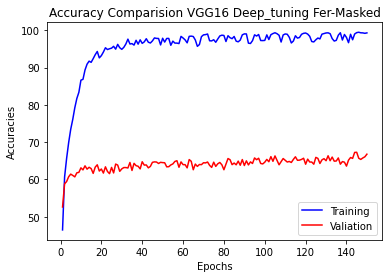

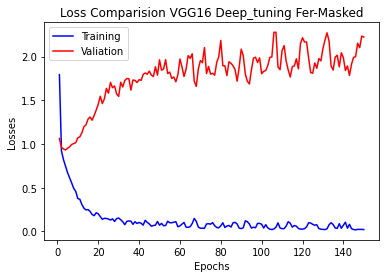

Test Accuracy of the model on the 4250 test images: 50.16470588235295 %


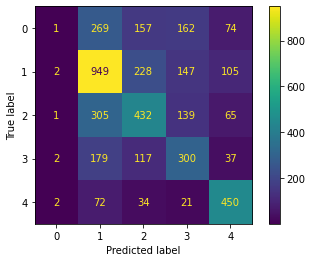

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 14531
Size Of Test Dataset 4250
Size Of Validation Dataset 2564
Images batch shape: torch.Size([64, 3, 72, 72])
Labels batch shape: torch.Size([64])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


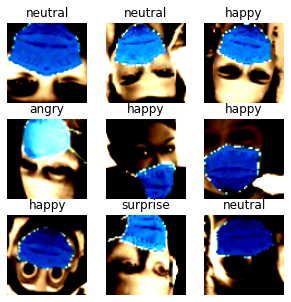

Device: cuda:0
Total Steps 228
Epoch [1/150], Training Loss: 1.9058, Validation Loss: 1.2376, Training Accuracy: 36.01%, Validation Accuracy: 47.7769,
Epoch [2/150], Training Loss: 1.1509, Validation Loss: 1.0952, Training Accuracy: 50.72%, Validation Accuracy: 53.4711,
Epoch [3/150], Training Loss: 1.0378, Validation Loss: 1.0031, Training Accuracy: 54.54%, Validation Accuracy: 57.1763,
Epoch [4/150], Training Loss: 0.9766, Validation Loss: 0.9906, Training Accuracy: 57.28%, Validation Accuracy: 58.8144,
Epoch [5/150], Training Loss: 0.9262, Validation Loss: 0.9516, Training Accuracy: 59.51%, Validation Accuracy: 61.5055,
Epoch [6/150], Training Loss: 0.8926, Validation Loss: 0.9407, Training Accuracy: 61.28%, Validation Accuracy: 59.5164,
Epoch [7/150], Training Loss: 0.8762, Validation Loss: 0.9202, Training Accuracy: 62.46%, Validation Accuracy: 62.0125,
Epoch [8/150], Training Loss: 0.8507, Validation Loss: 0.9154, Training Accuracy: 63.68%, Validation Accuracy: 60.7644,
Epoch [9/

Epoch [69/150], Training Loss: 0.0855, Validation Loss: 1.9670, Training Accuracy: 97.08%, Validation Accuracy: 64.3916,
Epoch [70/150], Training Loss: 0.0857, Validation Loss: 2.0089, Training Accuracy: 96.89%, Validation Accuracy: 65.0156,
Epoch [71/150], Training Loss: 0.0851, Validation Loss: 2.0419, Training Accuracy: 97.10%, Validation Accuracy: 63.7285,
Epoch [72/150], Training Loss: 0.0888, Validation Loss: 2.1421, Training Accuracy: 97.04%, Validation Accuracy: 64.9376,
Epoch [73/150], Training Loss: 0.0783, Validation Loss: 2.2183, Training Accuracy: 97.17%, Validation Accuracy: 64.5086,
Epoch [74/150], Training Loss: 0.0871, Validation Loss: 2.0062, Training Accuracy: 97.01%, Validation Accuracy: 65.0546,
Epoch [75/150], Training Loss: 0.0800, Validation Loss: 1.9591, Training Accuracy: 97.30%, Validation Accuracy: 63.8456,
Epoch [76/150], Training Loss: 0.0781, Validation Loss: 2.1338, Training Accuracy: 97.38%, Validation Accuracy: 63.8066,
Epoch [77/150], Training Loss: 0

Epoch [137/150], Training Loss: 0.0501, Validation Loss: 2.1812, Training Accuracy: 98.34%, Validation Accuracy: 65.2886,
Epoch [138/150], Training Loss: 0.0442, Validation Loss: 2.3529, Training Accuracy: 98.46%, Validation Accuracy: 65.4836,
Epoch [139/150], Training Loss: 0.0434, Validation Loss: 2.5500, Training Accuracy: 98.49%, Validation Accuracy: 64.0796,
Epoch [140/150], Training Loss: 0.0502, Validation Loss: 2.2561, Training Accuracy: 98.28%, Validation Accuracy: 64.8206,
Epoch [141/150], Training Loss: 0.0502, Validation Loss: 2.3354, Training Accuracy: 98.37%, Validation Accuracy: 65.2496,
Epoch [142/150], Training Loss: 0.0441, Validation Loss: 2.5456, Training Accuracy: 98.56%, Validation Accuracy: 64.7816,
Epoch [143/150], Training Loss: 0.0463, Validation Loss: 2.4967, Training Accuracy: 98.45%, Validation Accuracy: 65.0156,
Epoch [144/150], Training Loss: 0.0481, Validation Loss: 2.3712, Training Accuracy: 98.41%, Validation Accuracy: 64.6256,
Epoch [145/150], Trainin

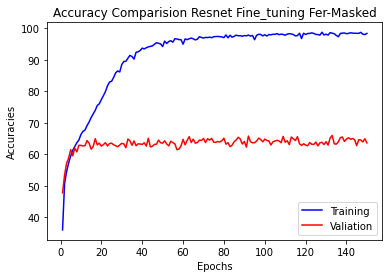

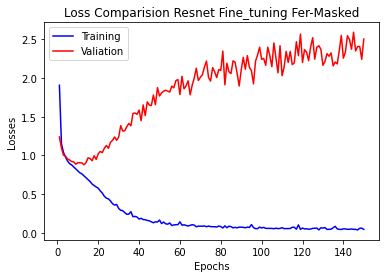

Test Accuracy of the model on the 4250 test images: 48.04705882352941 %


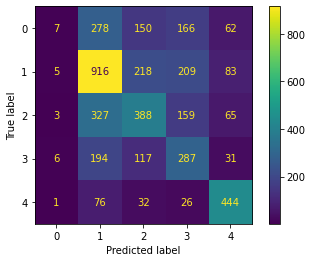

In [60]:

train_paths=['C:/Datasets/Datasets/Natural-Faces/train','C:/Datasets/Datasets/tiny/train','C:/Datasets/Datasets/Masked-fer2013/train']
test_paths=['C:/Datasets/Datasets/Natural-Faces/test','C:/Datasets/Datasets/tiny/test','C:/Datasets/Datasets/Masked-fer2013/test']

mdl_path='C:/Datasets/Datasets/Models/'
img_path='C:/Datasets/Datasets/Images/'  # CHANGE ALL 4 PATHS BASED ON UR FOLDER LOCATIONS (FOR MODEL/IMG PATH MAKE SURE TO CREATE FOLDERS)

mn=[[0.5236, 0.5236, 0.5236],[0.5422, 0.4674, 0.4349],[0.4652, 0.5198, 0.5736],[0.5074, 0.5074, 0.5074]]
sd=[[0.2351, 0.2351, 0.2351],[0.2665, 0.2500, 0.2517],[0.2354, 0.2363, 0.2666],[0.2551, 0.2551, 0.2551]]


batch_size=64
image_size=(72,72)
num_epochs=150
learning_rate=0.0001

dtaname=['Natural-Faces','Tiny','Fer-Masked','Fer']

# mdls=[torchvision.models.shufflenet_v2_x0_5(),torchvision.models.mobilenet_v3_small(),torchvision.models.mobilenet_v2(),torchvision.models.mnasnet0_5()]
# mdlname=['Shufflnet','MobileNetV3','MobileNetv2','MnasNet'] 

mdls=[torchvision.models.vgg16(weights=False),torchvision.models.resnet50(weights=False),torchvision.models.alexnet(weights= None)]  # CHANGE THIS ACCORDING TO NEED
mdlname=['VGG-16 Fine_tuning','VGG16 Deep_tuning','Resnet Fine_tuning','Resnet Deep_tuning'] # UPDATE BASED ON LIST ABOVE


for i in range(0,len(train_paths)):
    for k in range (0,len(mdls)):
        
        train_folder=train_paths[i]
        test_folder=test_paths[i]
        train_loader,test_loader,val_loader,lablist=load_data(train_folder,test_folder,batch_size,image_size,mn[i],sd[i])
        
        # mean, std = batch_mean_and_sd(train_loader)
        # print("mean and std: \n", mean, std)
        
        img_show(train_loader,lablist)
        model=mdls[k]#model reinitialized to prevent transfer learning on the other data sets
        
        
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=5,gamma=0.5) # SCHEDULED LEARNING RATE

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Device: {}".format(device))
        model.to(device)
        
        #print('----------PARAMETERS----------') #PRINTING MODEL AND NO OF PARAMTERS FOR A GIVEN INPUT SIZE
        #summary(model, (3,48,48))
        # print('----------FLOPS----------')
        # count_ops(model, torch.rand(1,3,48,48).to(device))
        
        
        model,t_acc,v_acc,t_loss,v_loss,epc=train_model(num_epochs,train_loader,val_loader) # TRAINING MODEL
        
        title=mdlname[k]+' '+dtaname[i]
        grp_show(epc,[t_acc,v_acc],['Training','Valiation'],['b','r'],'Epochs','Accuracies','Accuracy Comparision '+title,img_path) #DISPLAYING AND STORING GRAPHS
        grp_show(epc,[t_loss,v_loss],['Training','Valiation'],['b','r'],'Epochs','Losses','Loss Comparision '+title,img_path)
    
        test_model(model,test_loader)  # TESTING MODEL
        torch.save(model, mdl_path+title) # SAVING MODEL
        torch.cuda.empty_cache() 

    
    
    
